# Main

In [7]:
from skimage.transform import iradon
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def readData(directory):
    angle_pattern = re.compile(r"(-?\d+_\d+)\s*Deg")
    angle_to_counts = {}
    distances_ref = None
    for fname in os.listdir(directory):
        if not fname.endswith(".dat"):
            continue

        match = angle_pattern.search(fname)
        if not match:
            raise ValueError(f"Angle not found in filename: {fname}")

        angle = float(match.group(1).replace("_", "."))

        data = pd.read_csv(
            os.path.join(directory, fname),
            sep=r"\s+",
            skiprows=1,
            names=["Distance", "Counts"]
        )

        # if distances_ref is None:
        if (distances_ref is None):
            distances_ref = data["Distance"].to_numpy()
        elif (distances_ref != data["Distance"].to_numpy()):
            raise ValueError("Distance grid mismatch in file: " + fname)

        angle_to_counts[angle] = data["Counts"].to_numpy()

    angles = np.array(sorted(angle_to_counts.keys()))
    # Build 2D array: rows = distance, cols = angle
    counts_2d = np.column_stack([angle_to_counts[a] for a in angles])
    return counts_2d, distances_ref, angles

def display_image(count, distance, angles):
    plt.figure()
    plt.imshow(
        count,
        origin="lower",
        aspect="auto",
        extent=[
            angles[0], angles[-1],
            distance[0], distance[-1]],
        cmap="gray_r"
    )
    plt.xlabel("Angle (deg)")
    plt.ylabel("Distance (mm)")
    plt.colorbar(label="Counts")
    plt.show()
    return


In [3]:

directory = "./data/Preliminary Scan - 2026-01-09"
countArr, distance, angles = readData(directory)


In [10]:
print(distance)

[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  48.5
 49.  49.5 50. ]


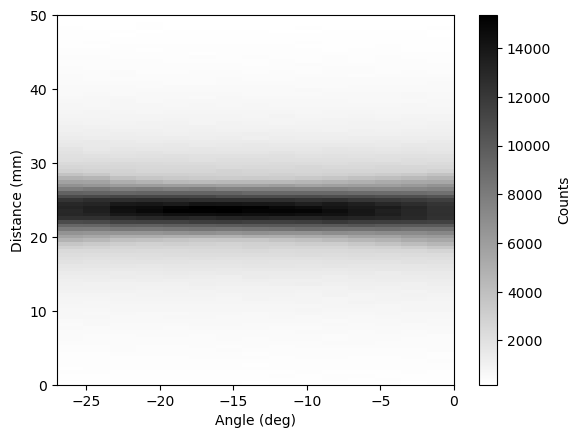

In [13]:
display_image(countArr, distance, angles)